<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2021/blob/master/11-gans/MLDM_2021_seminar11_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implement a GAN with convolutional architecture (2 points)

Build your own CNN architecture to improve the quality of generated images for the same dataset we used during the practical session.

You may reuse the code given below, or you may change/improve it as well.

### Some words before starting
*   The input to the generator is a series of randomly generated numbers called latent sample. Once trained, the generator can produce  images from latent samples
*   The discriminator is a classifier trained using the supervised learning. It classifies whether an image is real (1) or not (0).


![image](https://drive.google.com/uc?export=view&id=1LFkBuTngqCwOjnt2SE1j398SaQs7BSkY)


In [1]:
import numpy as np
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
from tqdm import tqdm

from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import clear_output

2.7.0


In [2]:
lfw = tfds.image_classification.LFW()
lfw.download_and_prepare()
ds = lfw.as_dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompletePJZCY9/lfw-train.tfrecord


  0%|          | 0/13233 [00:00<?, ? examples/s]

Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [3]:
def get_img(x):
  return x['image'][80:-80,80:-80]

data = np.array([
  np.array(Image.fromarray(img.numpy()).resize((36, 36)))
  for img in tqdm(ds['train'].map(get_img))
])

100%|██████████| 13233/13233 [00:05<00:00, 2577.28it/s]


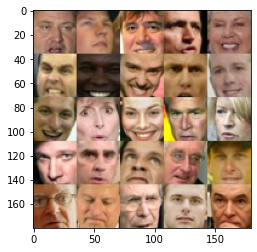

In [4]:
import matplotlib.pyplot as plt
plt.imshow(data[:25].reshape(5,5,36,36,3).transpose(0,2,1,3,4).reshape(5*36,5*36,3))

In [5]:
X_train = data.astype('float32') 

In [6]:
X_train.shape

(13233, 36, 36, 3)

# Seminar architecture

In [9]:
# transform
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

#fill them 
LATENT_DIM =  32 
#...
ll = tf.keras.layers
generator = tf.keras.Sequential([
  ll.Dense(32, input_shape=(LATENT_DIM,), activation='relu'),
  ll.Dense(64, activation='relu'),
  ll.Dense(36 * 36 * 3, activation='sigmoid'),
  ll.Reshape((36, 36, 3)),
])

discriminator = tf.keras.Sequential([
  ll.Reshape((36 * 36 * 3,), input_shape=(36, 36, 3)),
  ll.Dense(64, activation='relu'),
  ll.Dropout(0.1),
  ll.Dense(32, activation='relu'),
  ll.Dropout(0.1),
  ll.Dense(1),
])

generator.summary()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 3888)              252720    
                                                                 
 reshape (Reshape)           (None, 36, 36, 3)         0         
                                                                 
Total params: 255,888
Trainable params: 255,888
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)        

In [10]:
def gen_images(num):
  return generator(tf.random.normal(shape=(num, LATENT_DIM)))

# @tf.function decorator below compiles the function
# it decorates into a static graph. This improves the performance
# but there are some pitfalls one should be aware of when using it,
# check out https://www.tensorflow.org/guide/function
# for more details
@tf.function
def forward(batch):
  real = batch
  fake = gen_images(len(batch))

  shape = (len(batch), 1)
  labels_real = tf.ones (shape=shape)
  ### Optional regularization technique:
  ### set small amount of the 'real' labels
  ### to being 'fake':
  # labels_real = tf.cast(
  #     tf.random.uniform(shape=shape) > 0.1,
  #     'float32'
  # )
  labels_fake = tf.zeros(shape=shape)

  X = tf.concat([real, fake], axis=0)
  y = tf.concat([labels_real, labels_fake], axis=0)

  # Note: it's important to call the discriminator with `training=True`
  #       to make use of the Dropout layers.
  loss = tf.reduce_mean(
      tf.nn.sigmoid_cross_entropy_with_logits(y, discriminator(X, training=True))
  )
  return loss

opt_d = tf.optimizers.RMSprop()
opt_g = tf.optimizers.RMSprop()

@tf.function
def disc_step(batch):
  with tf.GradientTape() as t:
    d_loss = forward(batch)
  grads = t.gradient(d_loss, discriminator.trainable_variables)
  opt_d.apply_gradients(zip(grads, discriminator.trainable_variables))
  return d_loss

@tf.function
def gen_step(batch):
  with tf.GradientTape() as t:
    g_loss = -forward(batch)
  grads = t.gradient(g_loss, generator.trainable_variables)
  opt_g.apply_gradients(zip(grads, generator.trainable_variables))
  return g_loss

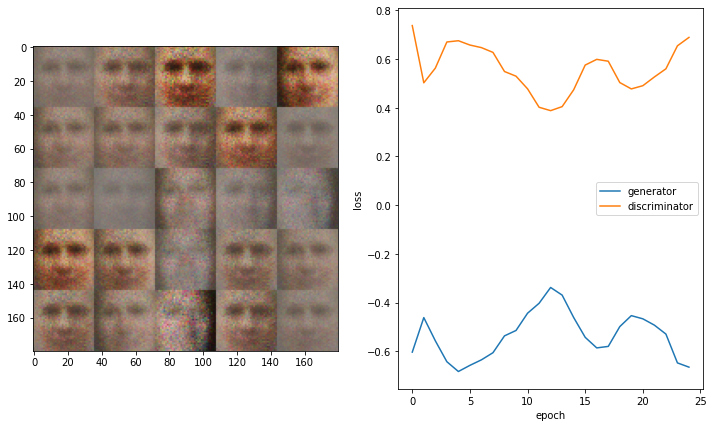

Done with epoch # 24


In [11]:
from tqdm import trange 
import matplotlib.pyplot as plt

#fill them
BATCH_SIZE = 256
N_EPOCHS = 25
NUM_DISC_STEPS = 5

i_disc_step = 0
losses_gen = []
losses_disc = []
for i_ep in range(N_EPOCHS):
  shuffle_ids = np.random.choice(len(X_train), len(X_train), replace=False)
  epoch_loss_gen = []
  epoch_loss_disc = []
  for i_img in trange(0, len(X_train), BATCH_SIZE):
    batch = X_train[shuffle_ids][i_img:i_img + BATCH_SIZE]

    if i_disc_step < NUM_DISC_STEPS:
      # discriminator update
      i_disc_step += 1
      epoch_loss_disc.append(disc_step(batch).numpy())
    else:
      # generator update
      i_disc_step = 0
      epoch_loss_gen.append(gen_step(batch).numpy())

  losses_gen.append(np.mean(epoch_loss_gen))
  losses_disc.append(np.mean(epoch_loss_disc))

  opt_d.learning_rate.assign(opt_d.learning_rate * 0.99)
  opt_g.learning_rate.assign(opt_g.learning_rate * 0.99)

  imgs = (gen_images(25).numpy() * 255).astype('uint8')
  clear_output(wait=True)
  plt.figure(figsize=(12, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(imgs.reshape((5, 5, 36, 36, 3)).transpose(0, 2, 1, 3, 4).reshape(36 * 5, 36 * 5, 3))
  plt.subplot(1, 2, 2)
  plt.plot(losses_gen, label='generator')
  plt.plot(losses_disc, label='discriminator')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print("Done with epoch #", i_ep)

# Let us try CNN 

In [48]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D,Flatten,Dropout , Input
from keras.models import Model, Sequential

In [33]:
# first tranformation option 
X_train = (data.astype('float32') / 255 - 0.5)*2
X_train = numpy.clip(X_train, -1, 1)

In [8]:
#Second tranformation option 
# we normalize the images to the range of -1, 1 because the generator’s final layer activation uses tanh.
X_train =(data.astype('float32')- 127.5) / 127.5


0.0 1.0 float32


In [49]:
# third tranformation option / we will use that 
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


In [9]:
X_train.shape

(13233, 36, 36, 3)

In [35]:
#reshape
import numpy
from skimage.transform import resize
new_shape = (32,32,3)
X_train_new = numpy.empty(shape=(X_train.shape[0],)+new_shape)
for idx in range(X_train.shape[0]):
    X_train_new[idx] = resize(X_train[idx], new_shape)

In [ ]:
X_train_new.shape


(13233, 32, 32, 3)

In [52]:
LATENT_DIM=32
CHANNELS = 3

def generator_with_cnn():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 * 3 * 3)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((3, 3, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=3, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    
    generator = Model(gen_input, x)
    return generator
generator=generator_with_cnn()
generator.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_24 (Dense)            (None, 1152)              38016     
                                                                 
 leaky_re_lu_105 (LeakyReLU)  (None, 1152)             0         
                                                                 
 reshape_13 (Reshape)        (None, 3, 3, 128)         0         
                                                                 
 conv2d_69 (Conv2D)          (None, 3, 3, 256)         819456    
                                                                 
 leaky_re_lu_106 (LeakyReLU)  (None, 3, 3, 256)        0         
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 6, 6, 256)        104

In [53]:
HEIGHT=36
WIDTH=36
def discriminator_with_cnn():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
        
    optimizer = tf.keras.optimizers.RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator
discriminator=discriminator_with_cnn()
discriminator.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 36, 36, 3)]       0         
                                                                 
 conv2d_73 (Conv2D)          (None, 34, 34, 256)       7168      
                                                                 
 leaky_re_lu_112 (LeakyReLU)  (None, 34, 34, 256)      0         
                                                                 
 conv2d_74 (Conv2D)          (None, 16, 16, 256)       1048832   
                                                                 
 leaky_re_lu_113 (LeakyReLU)  (None, 16, 16, 256)      0         
                                                                 
 conv2d_75 (Conv2D)          (None, 7, 7, 256)         1048832   
                                                                 
 leaky_re_lu_114 (LeakyReLU)  (None, 7, 7, 256)        0  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [54]:
generator = generator_with_cnn()
discriminator = discriminator_with_cnn()
discriminator.trainable = False
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)#Adversarial Model
optimizer = tf.keras.optimizers.RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [44]:
X_train.min()

0.0

In [55]:
import os
import time 
from PIL import Image

iters = 1000
batch_size = 16
OUTPUT = 'output2'
images=X_train
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(OUTPUT):
    os.mkdir(OUTPUT)
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    
    if step % 50 == 49:
        gan.save_weights('gan.h5')
        
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))
        
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (OUTPUT, images_saved))
        images_saved += 1

50/1000: d_loss: 0.6987,  a_loss: 0.6966.  (0.3 sec)
100/1000: d_loss: 0.6931,  a_loss: 0.6852.  (0.3 sec)
150/1000: d_loss: 0.7235,  a_loss: 0.7733.  (0.3 sec)
200/1000: d_loss: 0.6931,  a_loss: 0.7079.  (0.3 sec)
250/1000: d_loss: 0.6960,  a_loss: 0.7625.  (0.3 sec)
300/1000: d_loss: 0.6941,  a_loss: 0.7614.  (0.3 sec)
350/1000: d_loss: 0.6909,  a_loss: 0.7801.  (0.3 sec)
400/1000: d_loss: 0.6926,  a_loss: 0.7636.  (0.3 sec)
450/1000: d_loss: 0.6941,  a_loss: 0.7723.  (0.3 sec)
500/1000: d_loss: 0.6917,  a_loss: 0.8072.  (0.5 sec)
550/1000: d_loss: 0.6897,  a_loss: 0.7530.  (0.3 sec)
600/1000: d_loss: 0.6852,  a_loss: 0.8141.  (0.3 sec)
650/1000: d_loss: 0.6901,  a_loss: 0.7874.  (0.3 sec)
700/1000: d_loss: 0.7041,  a_loss: 0.8170.  (0.3 sec)
750/1000: d_loss: 0.6950,  a_loss: 0.7467.  (0.3 sec)
800/1000: d_loss: 0.6992,  a_loss: 0.7818.  (0.3 sec)
850/1000: d_loss: 0.7157,  a_loss: 0.7783.  (0.3 sec)
900/1000: d_loss: 0.6877,  a_loss: 0.8143.  (0.3 sec)
950/1000: d_loss: 0.6824,  a_

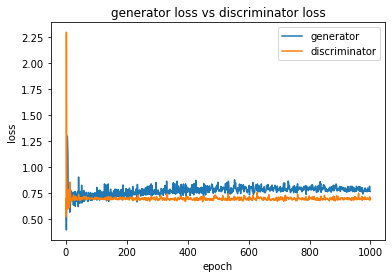

In [20]:
plt.plot(a_losses, label='generator')
plt.plot(d_losses, label='discriminator')
plt.title('generator loss vs discriminator loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [21]:
import imageio
import shutil
images_to_gif = []
for filename in os.listdir(OUTPUT):
    images_to_gif.append(imageio.imread(OUTPUT + '/' + filename))
    print(filename)
imageio.mimsave('generated_images.gif', images_to_gif)
shutil.rmtree(OUTPUT)

generated_8.png
generated_2.png
generated_7.png
generated_12.png
generated_11.png
generated_9.png
generated_4.png
generated_13.png
generated_15.png
generated_16.png
generated_5.png
generated_6.png
generated_10.png
generated_18.png
generated_17.png
generated_14.png
generated_3.png
generated_1.png
generated_0.png
generated_19.png


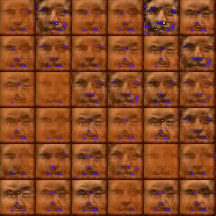

In [ ]:
from IPython.display import Image
Image(open('generated_images.gif', 'rb').read())

# Implement a [Wasserstein GAN](https://arxiv.org/abs/1704.00028) with gradient penalty term (4 points)

Replace previously build model with WGAN, you may reuse the code above. The dataset is the same, but you may use MNIST in case you want to perform a conditional generation.

## We tested this part on both MINST and FLW 

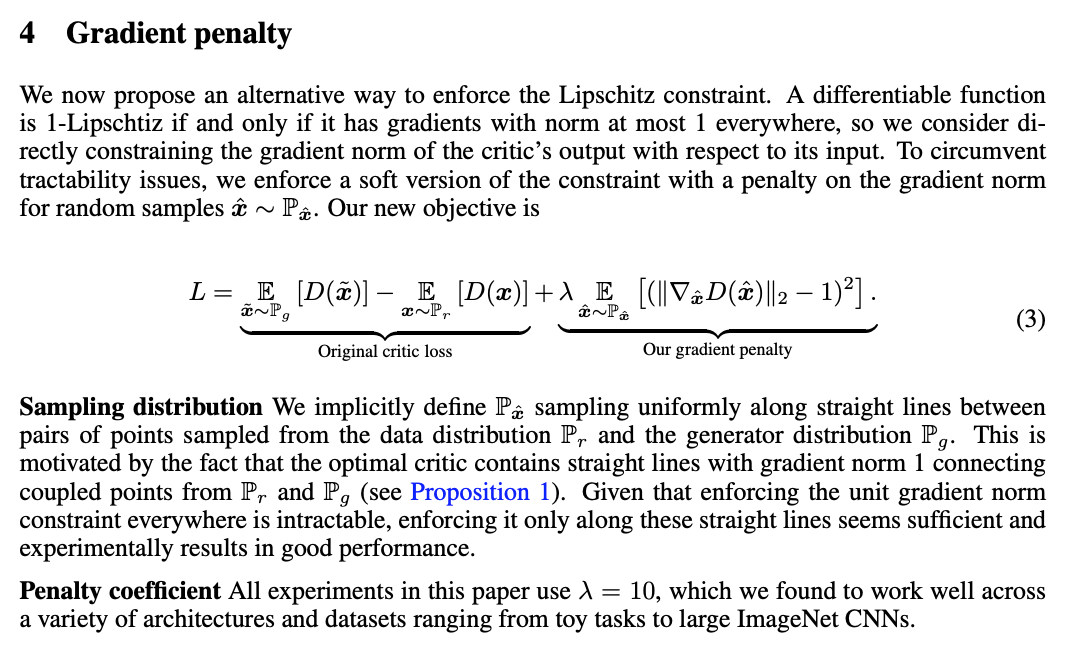


# **Some words before starting**
Here is the pseudo code of WGAN 

 ![image](https://drive.google.com/uc?export=view&id=1afGZloAIrVO_mX_onFLfudsDNqHfVNQL)

and here is a figure that makes things clearer

 ![image](https://drive.google.com/uc?export=view&id=1tZ5PmLdHGl1SFmKq3pWdk2B2yclNisSz)


- All existing GAN variants minimise the f divergence between the real data distribution  and the generated data distribution $$P_r(x) , P_g(x)$$
    - The usual GAN objective turns out to be very similar to Jenson-Shannon (JS) divergence, though the f-GAN paper explains how to use any -divergence you like
- f divergence is a function of the density ratio $$\dfrac{P_r(x)}{P_g(x)}$$
    - But what if the supports of the two distributions don’t overlap significantly? The density ratio will be infinite or zero everywhere they don’t overlap!
    - As long as the supports are disjoint, the f divergence will be constant since the density ratio is constant


- So, in order to use the EM distance we need to approximate the maximal f(x) 
- f(x)  is K-Lipschitz, which means the magnitude of the gradient is upper bounded by K everywhere
- We can force a network to model only K-Lipschitz functions by clamping the weights to a fixed box
- Therefore instead of a discriminator we use a critic which models f(x)

####so we can say that WGAN is a GAN that improves over the original loss function to improve training stability.

Here is the pseudo code of WGAN with Gradient Penalty 

![image](https://drive.google.com/uc?export=view&id=1mg7DfXAdU22vkD37JMgwH0-381Q15dT0)


#### A Gradient Penalty is a soft version of the Lipschitz constraint, which follows from the fact that functions are 1-Lipschitz iff the gradients are of norm at most 1 everywhere. The squared difference from norm 1 is used as the gradient penalty.

p.s we depended on some open sources  to do this part 

In [4]:
# imports 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

In [136]:
# PARAMS
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [242]:
#data
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

In [13]:
class WGAN(tf.keras.Model):

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        # generating noise from a uniform distribution

        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight
        )

        # losses of fake with label "1"
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

In [140]:
#  architecture for MINST
N_Z = 64

generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
]



In [17]:
# create the model
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)# train the model
# model
model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z,
    gradient_penalty_weight = 10.0
)

# **Result on MINST**

Epoch: 199 | disc_loss: 0.027178728953003883 | gen_loss: 0.3248763382434845


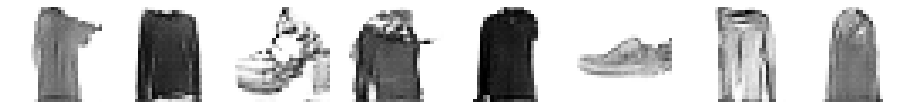

In [142]:
# train the model 
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
n_epochs = 200
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)

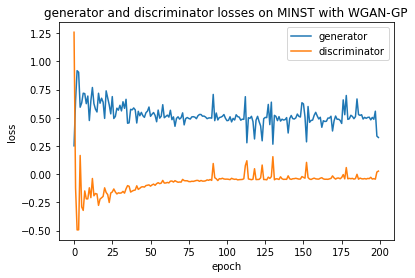

In [144]:
# results
#losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
plt.plot(losses.gen_loss, label='generator')
plt.plot(losses.disc_loss, label='discriminator')
plt.title('generator and discriminator losses on MINST with WGAN-GP')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()



---



In [5]:
# data from first section
# transform data
X_train = data.astype('float32') / 255
print(X_train.min(), X_train.max(), X_train.dtype)

0.0 1.0 float32


In [6]:
len(X_train) 

13233

In [7]:
from sklearn.model_selection import train_test_split

training_data, testing_data = train_test_split(X_train, test_size=3000, random_state=25)

print (len(training_data))

10233


In [8]:
# PARAMS
TRAIN_BUF=len(training_data)
BATCH_SIZE=512
DIMS = (36,36,3)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
LATEN_DIM=32
TEST_BUF=len(testing_data)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [9]:
train_dataset = training_data[None,:,:,:]
train_dataset.shape

(1, 10233, 36, 36, 3)

In [10]:
test_dataset = testing_data[None,:,:,:]
test_dataset.shape

(1, 3000, 36, 36, 3)

In [31]:
#modefied arch
generator = [
    tf.keras.layers.Dense(units=9 * 9 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(9, 9, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),]

#mod
discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="sigmoid"),
]

tf.keras.Sequential(discriminator).summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 17, 17, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________


In [11]:
# transform
#X_train = data.astype('float32') / 255
#print(X_train.min(), X_train.max(), X_train.dtype)

#fill them 
LATENT_DIM =  32 
#...
ll = tf.keras.layers
generator = tf.keras.Sequential([                      
  ll.Dense(64, activation='relu'),
  ll.Dense(36 * 36 * 3, activation='sigmoid'),
  ll.Reshape((36, 36, 3)),
])

discriminator = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=DIMS),
  ll.Dense(64, activation='relu'),
  ll.Dropout(0.1),
  ll.Dense(32, activation='relu'),
  ll.Dropout(0.1),
  ll.Dense(1),
])



In [14]:
# create model
N_Z=LATEN_DIM
gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.0005)# train the model
# model
model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z,
    gradient_penalty_weight = 10.0
)

In [ ]:
# train the model 
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
n_epochs = 200
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
# results
#losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])
plt.plot(losses.gen_loss, label='generator')
plt.plot(losses.disc_loss, label='discriminator')
plt.title('generator and discriminator losses on flw with WGAN-GP')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()